In [1]:
# Import dependencies
import nibabel as nib
import numpy as np
from numpy import linalg
import cv2
import scipy.io
import os
import imageio
from PIL import Image
import matplotlib.pyplot as plt
from utils import rotate
from utils import euclidean_distance_coords
from tabulate import tabulate

# Create list of subfolders - names of patient files to run the batch mode on
subfolders = next(os.walk(os.path.join('data')))[1]
subfolders = ['DBS_bG56','DBS_bG64','DBS_bT20']
print(subfolders)

['DBS_bG56', 'DBS_bG64', 'DBS_bT20']


In [2]:
# Load patient data and run 3rd component script for each patient. Output results to a table
data = []
for i in range(len(subfolders)):

    # Load patient data
    SAMPLE_NAME = subfolders[i]
    HULL_FILE_NAME = os.path.join('data_custom/' + SAMPLE_NAME,"hull_rh.mat")
    PRECT_FILE_NAME = os.path.join('data_custom/' + SAMPLE_NAME,"preop_ct.nii")
    POSTCT_FILE_NAME = os.path.join('data_custom/' + SAMPLE_NAME,"postop_ct.nii")
    FLUORO_FILE_NAME = os.path.join('data_custom/' + SAMPLE_NAME,"fluoro.tif")

    # Read .mat file of mask indices
    hull = scipy.io.loadmat(HULL_FILE_NAME)
    points_hull=np.array(hull['mask_indices'])

    # Read pre op CT
    prect = nib.load(PRECT_FILE_NAME)
    prect_data = np.nan_to_num(np.array(prect.get_fdata()))
    Tmatrix = np.transpose(prect.affine)

    # Read post op CT
    postct = nib.load(POSTCT_FILE_NAME)
    postct_data = np.nan_to_num(np.array(postct.get_fdata()))

    # Read fluoroscopy image
    fluoror = imageio.imread(FLUORO_FILE_NAME)
    fluoro = cv2.cvtColor(fluoror, cv2.COLOR_BGR2GRAY)

    #Load groud truth coordinates
    gt_dict = scipy.io.loadmat(os.path.join("data_custom/" + SAMPLE_NAME + "/electrode_locations/electrode_locs.mat"))
    gt = gt_dict['CortElecLoc']
    gt = np.concatenate(gt,axis=0)
    new_gt = []
    for i in range (len(gt)):
        new = np.concatenate(gt[i],axis = 0)
        new_gt.append(new)
    new_gt = np.array(new_gt)
    new_T = np.hstack((new_gt, np.ones((new_gt.shape[0],1))))
    Transformed = new_T @ np.linalg.inv(Tmatrix)
    
    aligned_coords_gt = np.delete(Transformed, obj=2, axis=1)
    aligned_coords_gt = np.delete(aligned_coords_gt, obj=2, axis=1)
    
    # Define the ideal pin, DBS lead, and electrode inputs for each of the 3 patients
    if SAMPLE_NAME == 'DBS_bG56':
        pins_ct = np.array([[72,77,45],[73, 73, 136],[206, 152, 138],[206,155,44], [139, 71, 113], [138,110,114]])
        pins_fl = np.array([[420, 700],[820, 590], [1294,415],[1305,425]])
        coords_2d = np.array([[588,239],[637,225],[689,213],[791,196],[540,261],[739,203]])
    if SAMPLE_NAME == 'DBS_bG64':
        pins_ct = np.array([[91,65,45],[91, 66, 132],[212, 167, 30], [213,165,135],[142, 107, 119],[142,67,120]])
        pins_fl = np.array([[420,590],[1250,630],[845,615],[855,625]])
        coords_2d = np.array([[916,276],[660,270],[865,267],[711,263],[814,261],[762,260],[966,289]])
    if SAMPLE_NAME == 'DBS_bT20':
        pins_ct = np.array([[110, 42, 138],[73, 72, 54],[73,70,139],[206, 145, 52], [147, 84, 111], [139, 66, 141]])
        pins_fl = np.array([[542, 1019],[1399, 539], [918, 800],[924,805]])
        coords_2d = np.array([[449,626],[490,575],[536,525],[587,485],[643,452],[706,430],[763,413],[830,405]])
    
    # Run third component function
    from fluoro_ct_alignment import project_to_2d
    aligned_coords = project_to_2d(postct_data,fluoro,pins_fl,pins_ct,coords_2d)
    
    aligned_coords_gt = aligned_coords_gt[0:len(aligned_coords),:]
    
    #Append results from this patient
    data.append(SAMPLE_NAME)
    data.append(aligned_coords)
    data.append(aligned_coords_gt)
    data.append(np.mean(np.abs(aligned_coords_gt - aligned_coords)))
    data.append(euclidean_distance_coords(aligned_coords, aligned_coords_gt))

data = list(data)

fluoro_ct_alignment.py successfully executed.
fluoro_ct_alignment.py successfully executed.
fluoro_ct_alignment.py successfully executed.


In [3]:
# Print results of batch to a table
patients = [data[0], data[5], data[10]]
predict = [data[1], data[6], data[11]]
ground = [data[2], data[7], data[12]]
MAE = [data[3], data[8], data[13]]
EucDist = [data[4], data[9], data[14]]

table = zip(patients,predict,ground,MAE,EucDist)

headers=["Patient", "Predicted", "Ground Truth", "Mean Absolute Error", "Euclidean Distance"]

print(tabulate(table,headers))

Patient    Predicted                      Ground Truth                     Mean Absolute Error    Euclidean Distance
---------  -----------------------------  -----------------------------  ---------------------  --------------------
DBS_bG56   [[ -7.06164384   6.20254542]   [[123.83516896 104.7599179 ]                 89.2956               135.58
            [  8.98921233   9.66342417]    [124.78693433  96.72070848]
            [ 27.33784247  14.67169193]    [126.78471209  88.7246648 ]
            [ 66.33886986  27.55183863]    [128.68824323  80.63801526]
            [-18.97123288   6.6852424 ]    [130.59177442  73.55033688]
            [ 45.68886986  20.20644856]]   [133.39994806  66.36991545]]
DBS_bG64   [[229.97150786 105.14537498]   [[160.00000763  59.        ]                 29.4489               120.712
            [192.13506013  92.51094009]    [168.00000763  62.        ]
            [222.6893617  100.23831296]    [176.00000763  66.        ]
            [199.94116559  92.51828

DBS_bG56: orange = predicted, red = ground truth


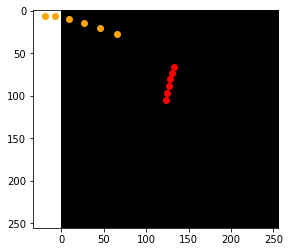

In [4]:
# Display predicted coordinates and ground truth coordinates on blank image for DBS_bG56
plt.imshow(np.zeros([256,256]),cmap='gray')
cor = data[1]
gt_cor = data[2]
plt.scatter(cor[:,0],cor[:,1],color='orange')
plt.scatter(gt_cor[:,0],gt_cor[:,1],color='red')
print('DBS_bG56: orange = predicted, red = ground truth')

DBS_bG64: orange = predicted, red = ground truth


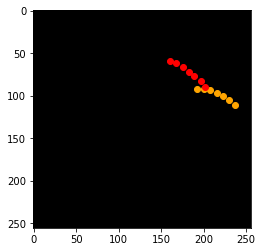

In [5]:
# Display predicted coordinates and ground truth coordinates on blank image for DBS_bG64
plt.imshow(np.zeros([256,256]),cmap='gray')
cor = data[6]
gt_cor = data[7]
plt.scatter(cor[:,0],cor[:,1],color='orange')
plt.scatter(gt_cor[:,0],gt_cor[:,1],color='red')
print('DBS_bG64: orange = predicted, red = ground truth')

DBS_bT20: orange = predicted, red = ground truth


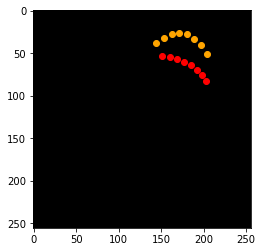

In [6]:
# Display predicted coordinates and ground truth coordinates on blank image for DBS_bG64
plt.imshow(np.zeros([256,256]),cmap='gray')
cor = data[11]
gt_cor = data[12]
plt.scatter(cor[:,0],cor[:,1],color='orange')
plt.scatter(gt_cor[:,0],gt_cor[:,1],color='red')
print('DBS_bT20: orange = predicted, red = ground truth')